In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chisquare, norm
from statsmodels.stats.multitest import multipletests

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import chisquare, norm
import scipy.sparse as sp
from statsmodels.stats.multitest import multipletests

In [ ]:
import sys
sys.path.append("..")

from SIGMOD import SIGMOD_SVLR as svlr

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

ModuleNotFoundError: No module named 'adjustText'

In [8]:
import scvelo
from sklearn.decomposition import NMF
from sklearn.preprocessing import minmax_scale

In [9]:
sc.set_figure_params(vector_friendly=True, dpi_save=300) 
sns.set_theme(style="white") 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

In [10]:
stdata = sc.read_h5ad("/home/liuchang/3.0_Result/4.0_NGDeonv/0315/PDAC/Data/st.h5ad")
stdata.obs["imagerow"] = stdata.obs["x"]
stdata.obs["imagecol"] = stdata.obs["y"]
stdata.var.index = stdata.var.features
stdata.var_names_make_unique() 
stdata.raw = stdata

In [11]:
sc.pp.normalize_total(stdata, target_sum=1e4)
sc.pp.log1p(stdata)

In [12]:
#### 
lr_df = pd.read_csv("/home/liuchang/4.0_Resource/lr/human_lr_pair.txt",sep="\t")
lr_df = lr_df[(lr_df['ligand_gene_symbol'].isin(stdata.var_names)) & 
              (lr_df['receptor_gene_symbol'].isin(stdata.var_names))]

ligand = [ pd.Series(i).values for i in lr_df.ligand_gene_symbol.values]
receptor = [ pd.Series(i).values for i in lr_df.receptor_gene_symbol.values]

In [13]:
layer = pd.read_csv("/home/liuchang/3.0_Result/4.0_NGDeonv/0315/PDAC/Data/layer_manual_PDAC.csv",index_col=0)

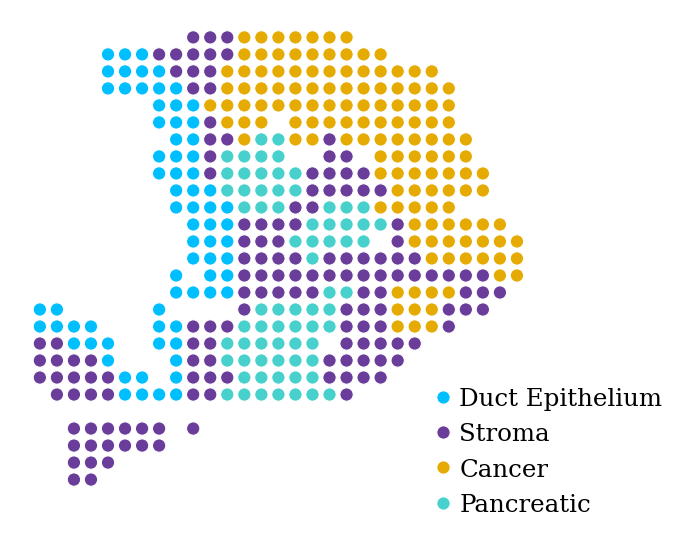

In [41]:
#00BFFF (天蓝)
#6A3D9A (紫罗兰)
#E6AB02 (金黄)
#48D1CC (青绿)
palette = ["#00BFFF", "#6A3D9A","#E6AB02", "#48D1CC"]

sns.scatterplot(data=layer, x="x", y="y", hue="Region", palette=palette)

plt.legend(
    loc='lower right',
    bbox_to_anchor=(1.25, -0.05),
    borderaxespad=0.,
    fontsize=11, 
    frameon=False
)

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.subplots_adjust(right=1)

plt.savefig("./Figure/1_PDAC_Manual_Anno.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()

Spatial Variable Ligand Receptor Interaction Identification

In [26]:
KNN_df=svlr.get_KNN_graph(layer,1,)

In [27]:
cells = np.array(stdata.obs_names)
cells_id_tran = dict(zip(cells, range(cells.shape[0])))
KNN_df['Cell1_ID'] = KNN_df['Cell1'].map(cells_id_tran)
KNN_df['Cell2_ID'] = KNN_df['Cell2'].map(cells_id_tran)

In [28]:
layer["cell_order"] =  layer.index.map(cells_id_tran)

In [ ]:
n = 3  # Number of subspaces desired
mx = 2  # Overlap in x-axis
my = 2  # Overlap in y-axis

# Calculate the range and step size for both axes
x_range = [layer['x'].min(), layer['x'].max()]
y_range = [layer['y'].min(), layer['y'].max()]
x_step = (x_range[1] - x_range[0] - mx * (n - 1)) / n
y_step = (y_range[1] - y_range[0] - my * (n - 1)) / n

subspaces = svlr.create_subspaces(layer, n, x_range, y_range, x_step, y_step, mx, my)
# Select subspaces that contain more than 10 points
selected_subspaces = {key: val for key, val in subspaces.items() if len(val) > 10}


In [30]:
G_df = KNN_df.copy()
dist_mat = sp.coo_matrix((G_df['Distance'], (G_df['Cell1_ID'], G_df['Cell2_ID'])), shape=(stdata.n_obs, stdata.n_obs))
dist_mat = dist_mat + sp.eye(dist_mat.shape[0])
dist_mat = dist_mat.toarray()

In [31]:
lr_res,lr_pair,ligands,receptors = svlr.run_svlr(ligand,
                               receptor,
                               dist_mat,
                               selected_subspaces,
                               stdata)

mean spots in each subspaces is:  57


  0%|          | 0/2114 [00:00<?, ?it/s]

In [51]:
# Convert results to DataFrame
lr_res_df = pd.DataFrame(lr_res, columns=list(selected_subspaces.keys())+['density_p', 'L_R_mean_strength', 'L_R_mean_z'])
lr_res_df.index = lr_pair
lr_res_df['ligands'] = ligands
lr_res_df['receptors'] = receptors
lr_res_df.index = lr_pair
lr_res_df = lr_res_df.fillna(1)
lr_res_df['mean_p'] = lr_res_df['L_R_mean_z'].apply(lambda z: 1 - norm.cdf(z) if z > 0 else norm.cdf(z)) # 基于标准正态分布计算互作强度的p值
# Apply Bonferroni correction for multiple testing on p-values and chi.p-values
lr_res_df['mean_fdr'] = multipletests(lr_res_df['mean_p'], method='bonferroni')[1]
lr_res_df['density_fdr'] = multipletests(lr_res_df['density_p'], method='bonferroni')[1]
lr_res_df['mean_fdr_log'] = -np.log10(lr_res_df['mean_fdr'])
lr_res_df['density_fdr_log'] = -np.log10(lr_res_df['density_fdr'])
lr_res_df['density_p_log'] = -np.log10(lr_res_df['density_p'])

In [52]:
lr_res_df.sort_values(["density_fdr_log"],ascending=False).iloc[0:10,:]

,Subspace_1_1,Subspace_1_2,Subspace_1_3,Subspace_2_1,Subspace_2_2,Subspace_2_3,Subspace_3_2,Subspace_3_3,density_p,L_R_mean_strength,L_R_mean_z,ligands,receptors,mean_p,mean_fdr,density_fdr,mean_fdr_log,density_fdr_log,density_p_log
LAMB1_ITGAV,3.886054,0.000000,0.601316,24.009058,3.479695,0.956067,0.160463,1.232914,3.810878e-20,1.827137,4.752351,LAMB1,ITGAV,1.005323e-06,2.125253e-03,8.056197e-17,2.672589,16.093870,19.418975
VCAM1_EZR,2.331633,1.936441,0.000000,21.525362,6.524429,1.075575,0.802317,0.821942,3.024900e-15,1.053738,0.443468,VCAM1,EZR,3.287137e-01,1.000000e+00,6.394639e-12,-0.000000,11.194184,14.519289
SPP1_ITGAV,3.886054,3.872881,8.418421,30.218297,7.829315,3.465743,0.641854,2.671313,4.077585e-15,1.326248,3.661228,SPP1,ITGAV,1.255045e-04,2.653164e-01,8.620014e-12,0.576236,11.064492,14.389597
AZGP1_ITGAV,2.331633,1.936441,1.803947,19.455616,3.334708,0.239017,0.000000,0.205486,1.100500e-14,1.433590,2.125104,AZGP1,ITGAV,1.678896e-02,1.000000e+00,2.326456e-11,-0.000000,10.633305,13.958410
S100A10_CFTR,6.606293,13.555085,4.209211,32.701993,13.048858,2.987709,1.444171,3.493255,7.013864e-14,0.951183,-0.662312,S100A10,CFTR,2.538856e-01,1.000000e+00,1.482731e-10,-0.000000,9.828938,13.154043
LTF_LRP1,5.051871,0.000000,0.601316,20.697464,8.699239,0.597542,1.123244,0.821942,1.047354e-13,1.061577,0.555577,LTF,LRP1,2.892502e-01,1.000000e+00,2.214106e-10,-0.000000,9.654802,12.979907
COL1A2_ITGAV,6.994898,2.904661,4.209211,27.734601,5.219543,2.868201,0.641854,5.548112,2.590583e-13,1.242474,2.451103,COL1A2,ITGAV,7.120968e-03,1.000000e+00,5.476492e-10,-0.000000,9.261498,12.586602
HSP90AA1_CFTR,5.051871,10.650424,3.006579,27.734601,8.264277,1.673117,1.123244,2.260342,3.055951e-13,1.092032,0.935748,HSP90AA1,CFTR,1.747014e-01,1.000000e+00,6.460280e-10,-0.000000,9.189749,12.514854
LAMB3_ITGB4,0.388605,4.841102,6.614474,11.590580,4.929569,14.938546,11.713834,35.549011,3.898281e-13,1.434861,7.499749,LAMB3,ITGB4,3.197442e-14,6.759393e-11,8.240966e-10,10.170092,9.084022,12.409127
CXCL1_ADRA2A,0.388605,1.936441,0.000000,13.660326,1.014911,0.239017,0.000000,0.000000,6.786857e-13,1.725147,2.132867,CXCL1,ADRA2A,1.646783e-02,1.000000e+00,1.434742e-09,-0.000000,8.843226,12.168331


In [53]:
lr_res_df.to_csv('./Results/SVLR/1_lr_res.csv')

In [54]:
lr_res_df_0_05 = lr_res_df[(lr_res_df['mean_fdr'] < 0.05) & (lr_res_df['L_R_mean_z'] > 0) & (lr_res_df['density_p'] < 1e-3)]

In [55]:
# Assume all Secereted for Kernel Estimation
lr_res_df_0_05["annotation"] = "Secreted Signaling"

In [60]:
lr_res_df_0_05.replace([np.inf, -np.inf], 12.5, inplace=True)

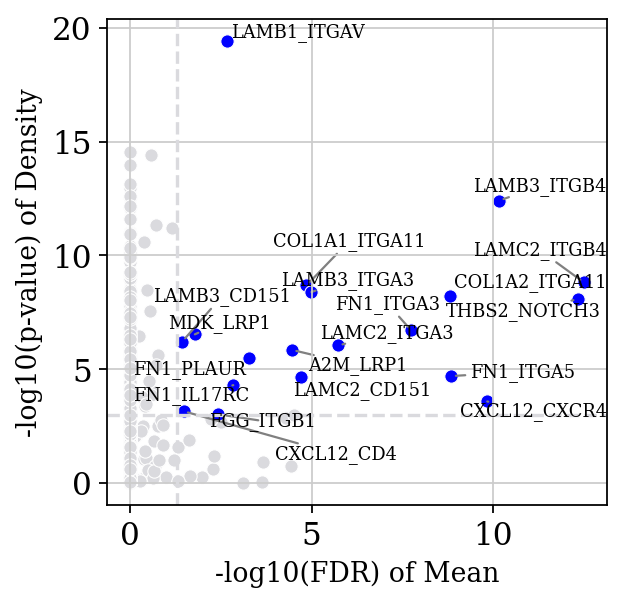

In [65]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

sns.scatterplot(data=lr_res_df, x="mean_fdr_log", y="density_p_log", color="#DADADE", ax=ax)

sns.scatterplot(data=lr_res_df_0_05, x="mean_fdr_log", y="density_p_log", color="blue", ax=ax)

plt.axhline(y=-np.log10(1e-3), ls='--', color='#DADADE') 
plt.axvline(x=-np.log10(0.05), ls='--', color='#DADADE') 

annotations = [
    ax.annotate(
        lr_res_df_0_05.index[i],
        (lr_res_df_0_05.mean_fdr_log[i], lr_res_df_0_05.density_p_log[i]),
        fontsize=8 
    )
    for i in range(lr_res_df_0_05.shape[0])
]

adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'))

plt.xlabel("-log10(FDR) of Mean", fontsize=12)
plt.ylabel("-log10(p-value) of Density", fontsize=12)

plt.savefig("./Figure/2_LR_density_vs_mean.pdf", format="pdf", bbox_inches="tight", dpi=1000)
plt.show()

In [66]:
lr_res_df[lr_res_df.index.str.contains("MMP1")]

,Subspace_1_1,Subspace_1_2,Subspace_1_3,Subspace_2_1,Subspace_2_2,Subspace_2_3,Subspace_3_2,Subspace_3_3,density_p,L_R_mean_strength,L_R_mean_z,ligands,receptors,mean_p,mean_fdr,density_fdr,mean_fdr_log,density_fdr_log,density_p_log
MMP1_CD44,5.829082,15.491525,9.621053,20.283514,8.699239,4.063285,1.604635,3.287770,0.000019,1.006337,0.078543,MMP1,CD44,0.468698,1.0,0.040804,-0.0,1.389297,4.714402
MMP1_ITGA2,2.720238,14.523305,11.425000,7.037138,5.654505,2.748692,1.925562,8.013939,0.004040,1.110932,1.222438,MMP1,ITGA2,0.110771,1.0,1.000000,-0.0,-0.000000,2.393576
MMP12_PLAUR,0.000000,0.000000,0.000000,0.000000,0.144987,0.956067,0.160463,3.287770,0.023790,1.378757,1.453767,MMP12,PLAUR,0.073006,1.0,1.000000,-0.0,-0.000000,1.623604


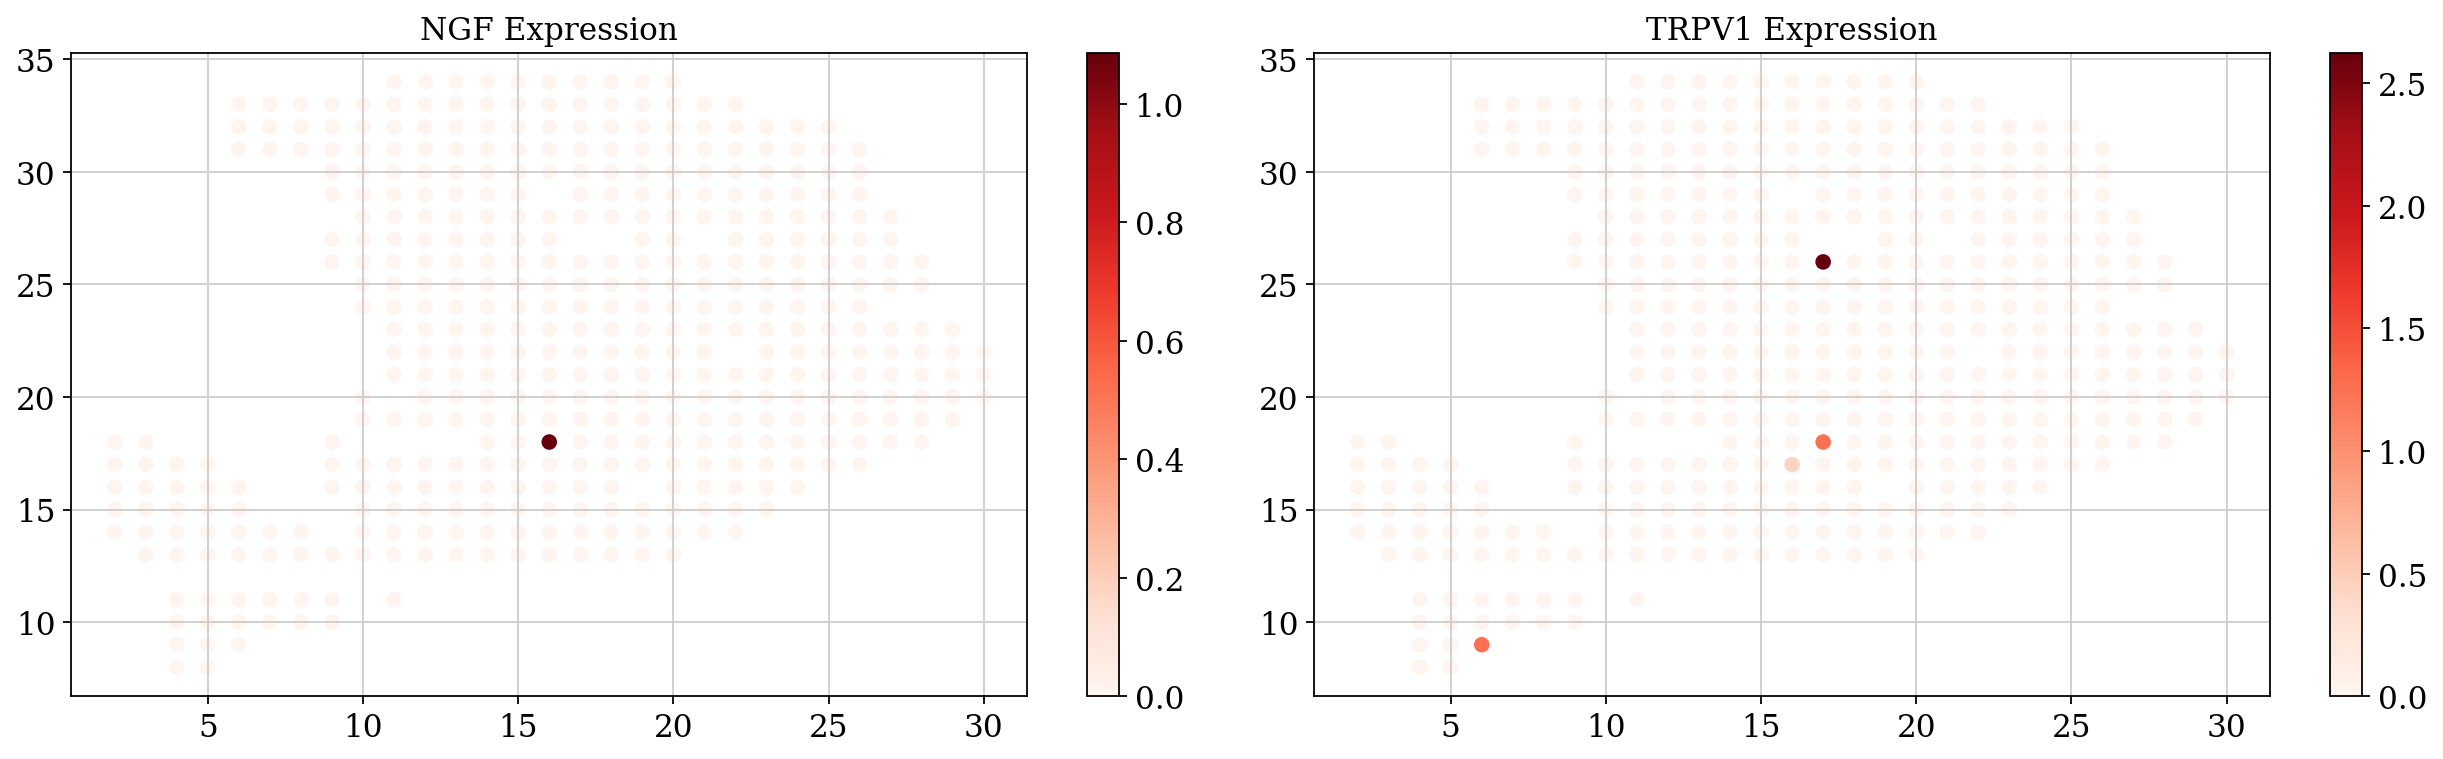

In [67]:
svlr.plotLR("NGF_TRPV1",stdata,layer)

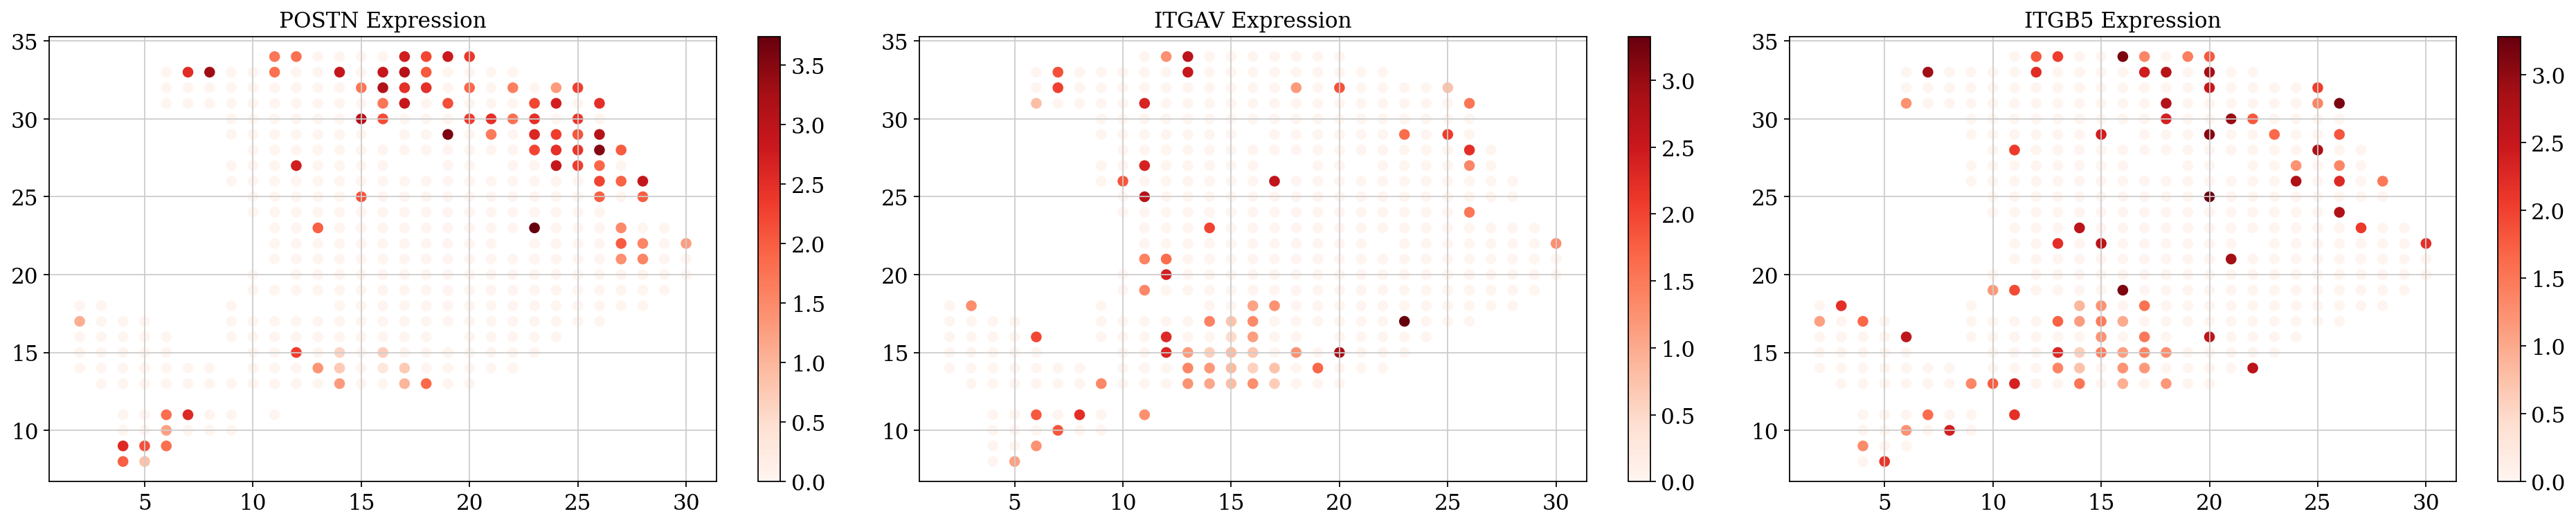

In [68]:
svlr.plotLR("POSTN_ITGAV_ITGB5",stdata,layer)

## Annotate region based on L-R interactions

In [69]:
lr_res = lr_res_df_0_05
pos = stdata.obs.loc[:,["x","y"]]
l_secrete = 6/2
l_contact = 2/3

niche_res,secrete_index,contact_index = svlr.Create_Niche(stdata,
                                                          pos,
                                                          l_secrete,
                                                          l_contact,
                                                          lr_res)

  0%|          | 0/19 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [70]:
niche_res_df = pd.concat(niche_res,axis=1)

In [71]:
niche_res_df.columns = secrete_index.append(contact_index)

# Convert Ligand Receptor to Niche
## Preprocess min-max normalization alongside lr axis

In [72]:
niche_res_numpy = niche_res_df.to_numpy()
niche_res_numpy_minmax = minmax_scale(niche_res_numpy, feature_range=(0,1), axis=0)

In [73]:
%%time
model = NMF(n_components=12, init='random', random_state=0)
A_ = model.fit_transform(niche_res_numpy_minmax)
B_ = model.components_

CPU times: user 7.19 ms, sys: 117 µs, total: 7.3 ms
Wall time: 6.63 ms


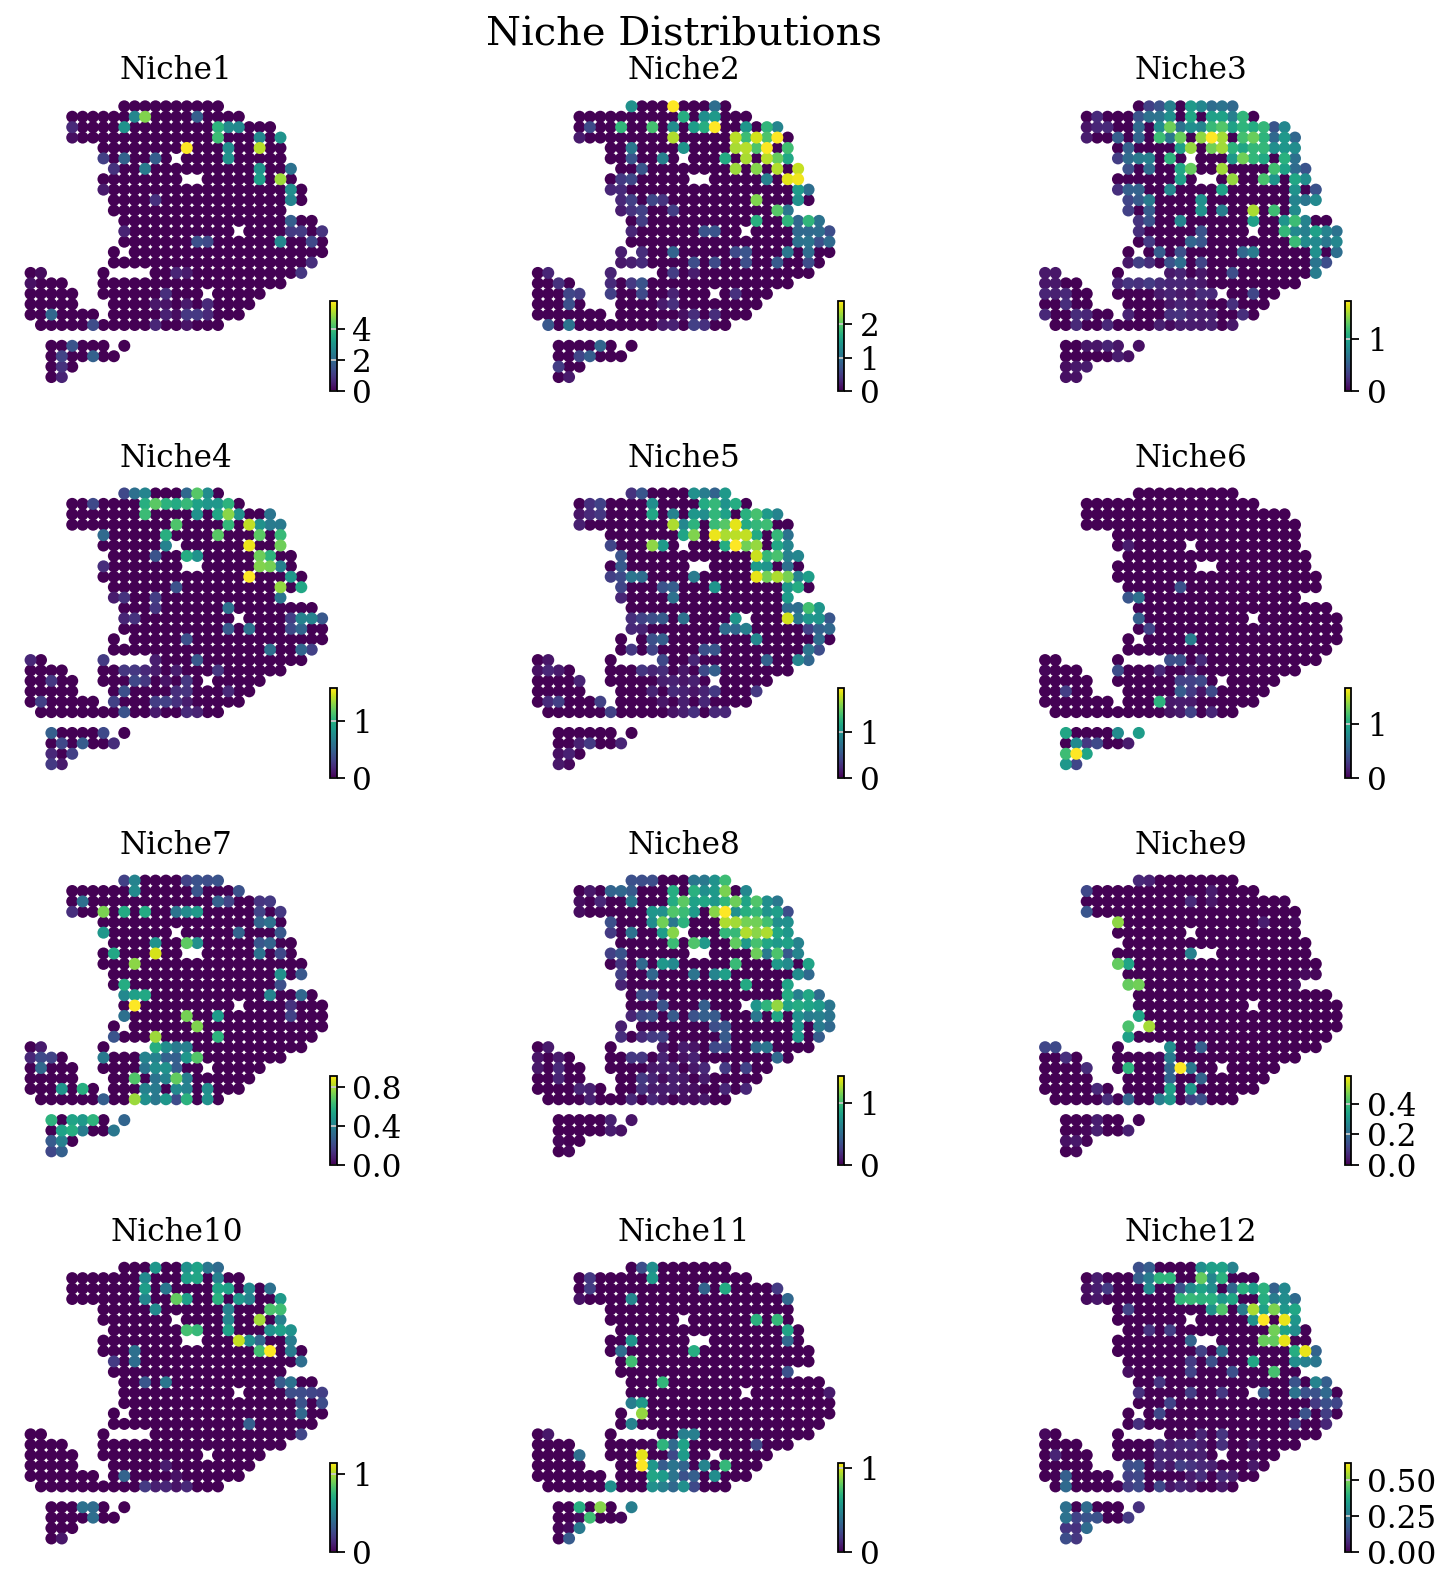

In [87]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.05, hspace=0.3)
fig.suptitle("Niche Distributions", fontsize=18, y=0.95, x=0.57)

axs = axs.flatten()

for i in range(12):
    stdata.obs["Topic"] = A_[:, i]
    scvelo.pl.scatter(
        stdata,
        alpha=1,
        x="x",
        y="y",
        color='Topic',
        title=f'Niche{i+1}',
        show=False,
        size=50000 / stdata.shape[0],
        ax=axs[i]
    )
    axs[i].set_aspect('equal', 'box')
    axs[i].set(xlabel=None, ylabel=None)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    for spine in axs[i].spines.values():
        spine.set_visible(False)

plt.savefig("./Figure/3_Niche_Distribution.pdf", format="pdf", bbox_inches="tight", dpi=1000)
plt.show()


In [93]:
A_df = pd.DataFrame(A_,columns = ["Niche"+ str(i+1) for i in range(12)])
A_df.to_csv("./Results/SVLR/2_niche12_res.csv",index=False)
B_df = pd.DataFrame(B_,index = ["Niche"+ str(i+1) for i in range(12)], columns = niche_res_df.columns)
B_df = B_df.T
B_df.to_csv("./Results/SVLR/3_lr_niche12.csv",index=True)

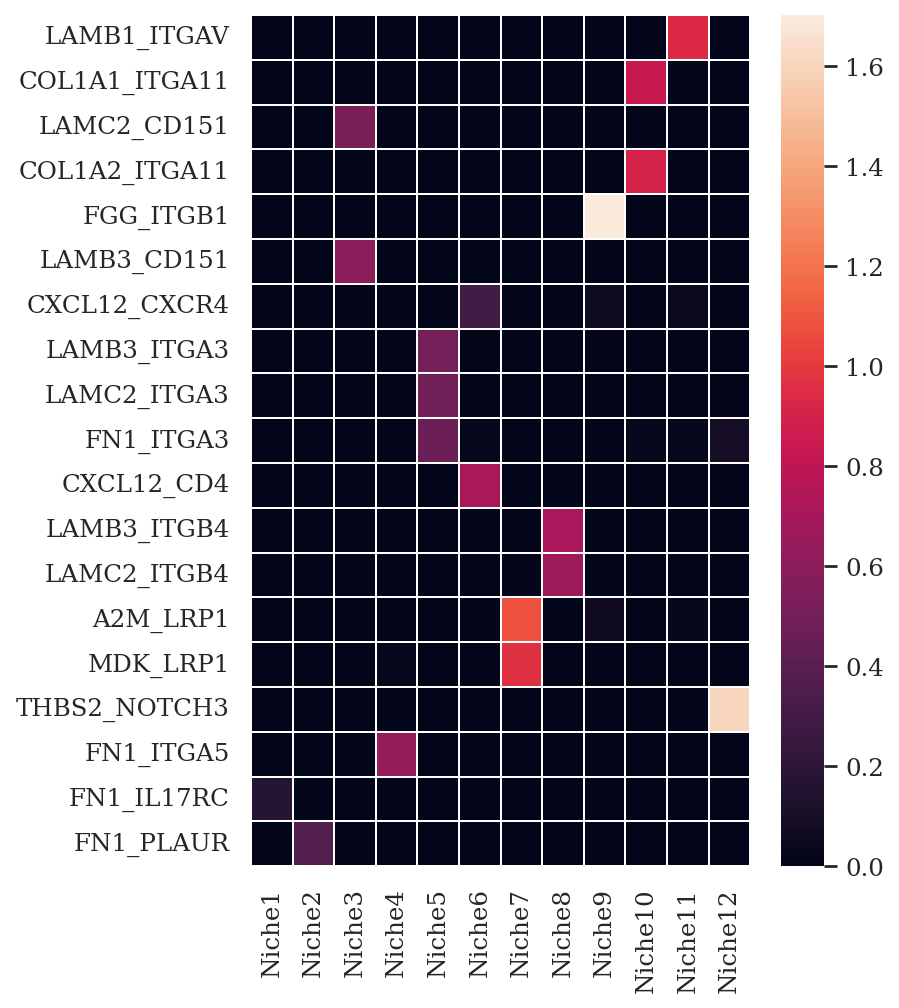

In [104]:
plt.figure(figsize=(5, 7))
sns.heatmap(B_df,linewidths=0.1, linecolor='white')
plt.savefig("./Figure/4_LR_2_Niche.pdf", format="pdf", bbox_inches="tight", dpi=1000)
plt.show()